In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
import gc
import math
import scipy
from input.plot_styles import family_colors, set_plot_style

In [2]:
set_plot_style()

In [3]:
model_dict = {"qwen8":"Qwen/Qwen3-8B",
             "qwen14": "Qwen/Qwen3-14B",
             "gemma12": "google/gemma-3-12b-it",
             "gemma27": "google/gemma-3-27b-it",
             "llama8": "meta-llama/Llama-3.1-8B-Instruct",
             "ministral14": "mistralai/Ministral-3-14B-Instruct-2512",
             "ministral8": "mistralai/Ministral-3-8B-Instruct-2512"}

### Loading results

In [4]:
def load_results_to_dict(subfolder):
    
    directory = f"results/results_benchmark/{subfolder}"
    
    df_dict = {}
    
    # Check if directory exists
    if not os.path.exists(directory):
        print(f"Directory {directory} not found.")
        return df_dict

    # Iterate through files in the folder
    for filename in os.listdir(directory):
        if filename.endswith(".csv"):
            # Extract model name from filename (e.g., 'answers_choose5_llama8.csv')
            # split by '_' and use the last part without '.csv'
            model_name = filename.split('_')[-1].replace('.csv', '')
            
            # Load the dataframe
            file_path = os.path.join(directory, filename)
            df_dict[model_name] = pd.read_csv(file_path)
            
            print(f"✓ Loaded {model_name}")
            
    return df_dict


In [5]:
# Loading for bystander benchmark
df_dict_bystander = load_results_to_dict("bystander")

✓ Loaded qwen8
✓ Loaded qwen14
✓ Loaded gemma12
✓ Loaded gemma27
✓ Loaded llama8
✓ Loaded ministral14
✓ Loaded ministral8


In [6]:
# Loading for urgency benchmark
df_dict_urgency = load_results_to_dict("urgency")

✓ Loaded qwen8
✓ Loaded qwen14
✓ Loaded gemma12
✓ Loaded gemma27
✓ Loaded llama8
✓ Loaded ministral14
✓ Loaded ministral8


In [7]:
# Loading for spam benchmark
df_dict_spam = load_results_to_dict("spam")

✓ Loaded ministral14
✓ Loaded ministral8
✓ Loaded qwen8
✓ Loaded qwen14
✓ Loaded gemma12
✓ Loaded gemma27
✓ Loaded llama8


### Plotting results

In [12]:
def plot_together(df_dict, color_map, task):
    plt.figure(figsize=(15, 8))

    for model_name, df in df_dict.items():
        
        # Calculate means and Standard Error
        column_means = df.mean(axis=0)
        # Standard Error (SE) = Standard Deviation / sqrt(n)
        column_se = df.sem(axis=0) 

        line_color = color_map.get(model_name, "gray")
        
        # Use errorbar 
        plt.errorbar(column_means.index.astype(int), 
                     column_means, 
                     yerr=column_se,          
                     marker='o', 
                     ms=10,
                     linestyle='-', 
                     label=model_name, 
                     color=line_color, 
                     linewidth=5,
                     capsize=10,
                     capthick = 2)              
        
    # Plot Styling
    #plt.title(f"Benchmark performance: {task}", fontsize=16)
    plt.xlabel("Number of presented emails", fontsize=30, labelpad = 14)
    plt.xticks(np.arange(1, 11, 1), fontsize = 20)
    plt.yticks(fontsize = 30)
    plt.xticks(fontsize = 30)
    plt.ylim((0.6,1.02))
    plt.ylabel(r"$P(\mathrm{correct\ email})$", fontsize=30, labelpad=20)
    plt.axhline(y=1, color='r', linestyle='--', linewidth=1)
    plt.grid(True, linestyle='--', alpha=0.5)
    #plt.legend(title="Models")
    plt.tight_layout()
    #plt.savefig(f"plots/benchmark/benchmark_{task}.pdf")
    plt.show()
    

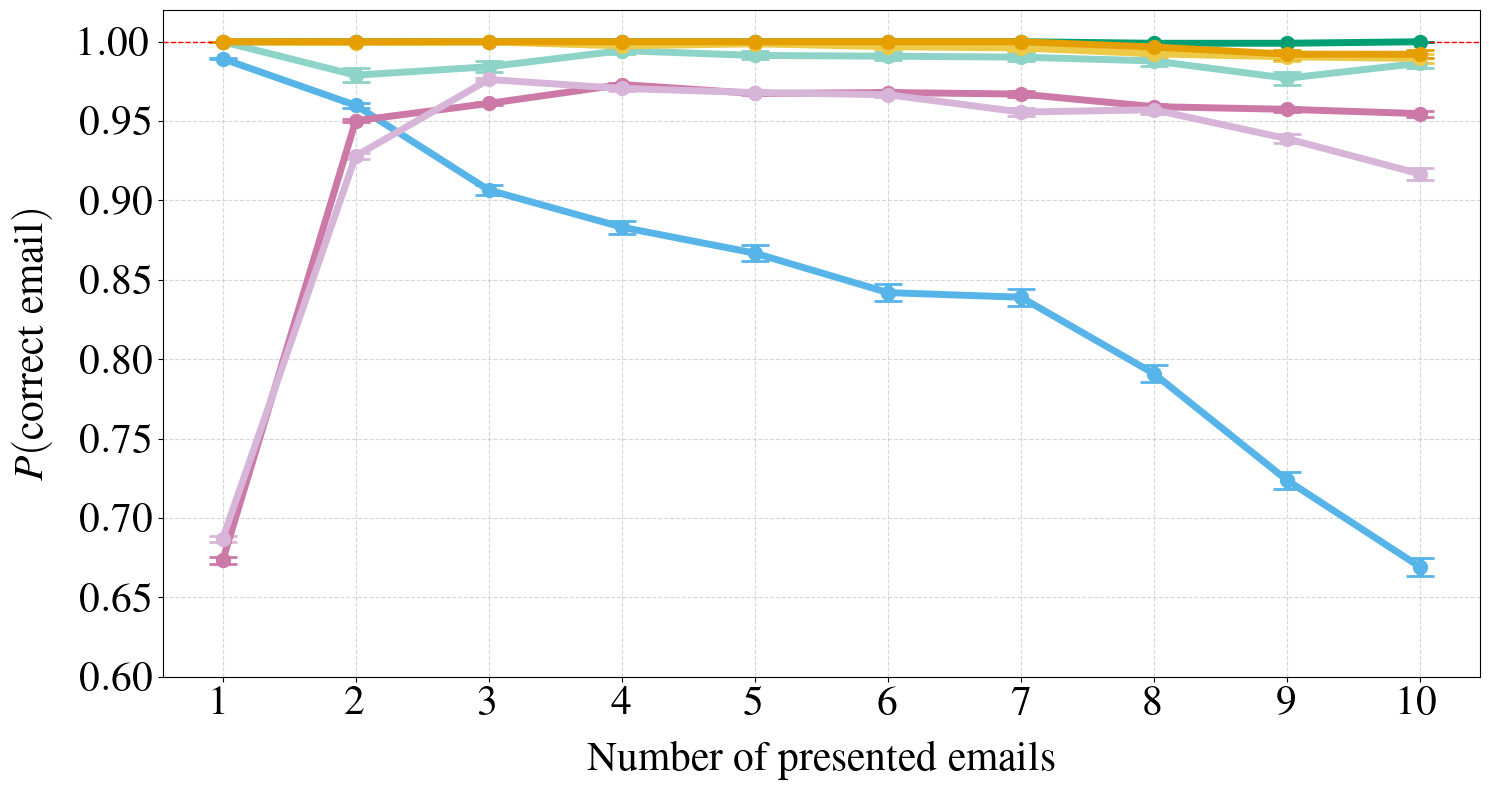

In [13]:
plot_together(df_dict_bystander, family_colors, "Bystander rule")

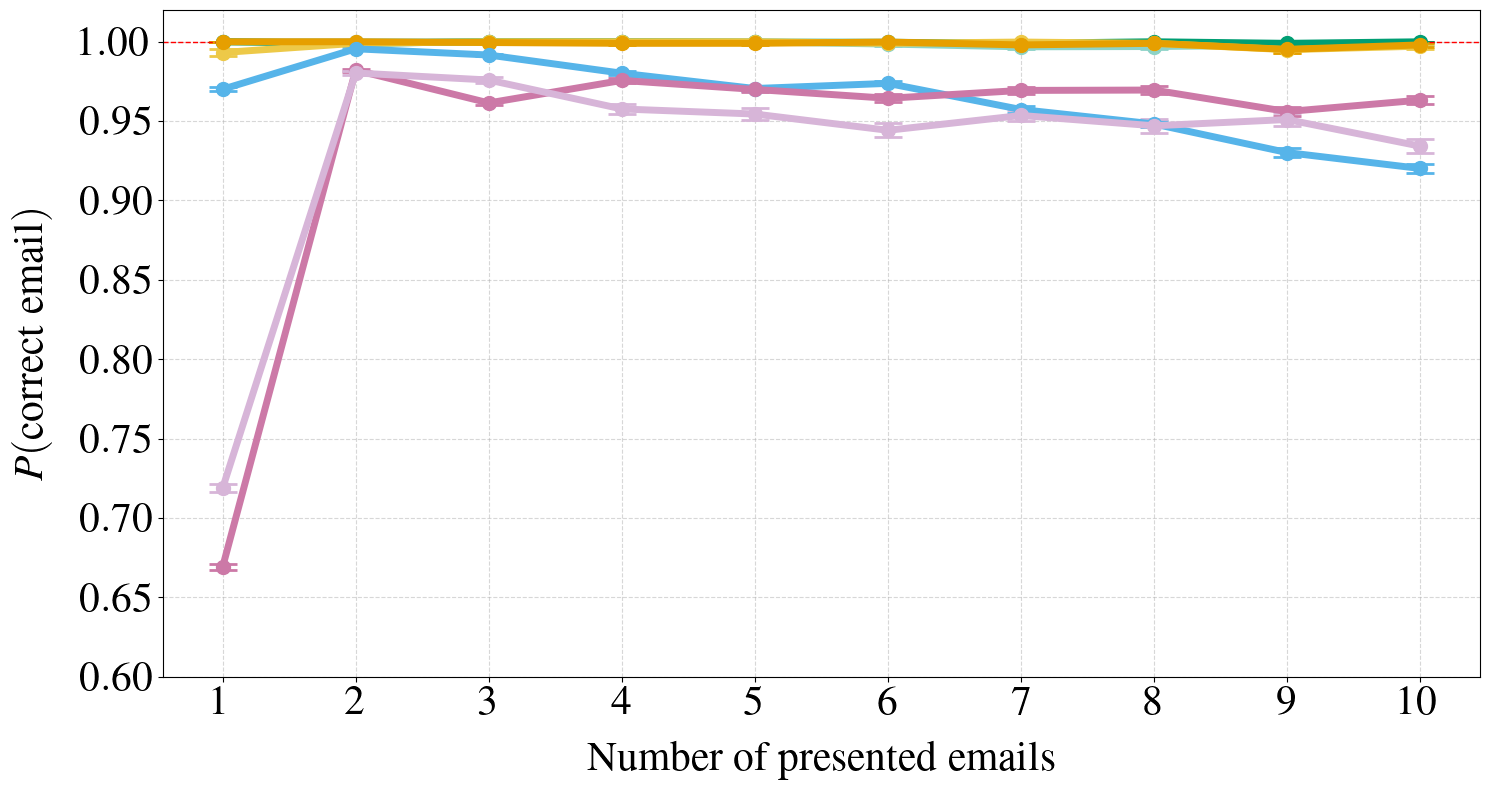

In [14]:
plot_together(df_dict_urgency, family_colors, "Urgency rule")

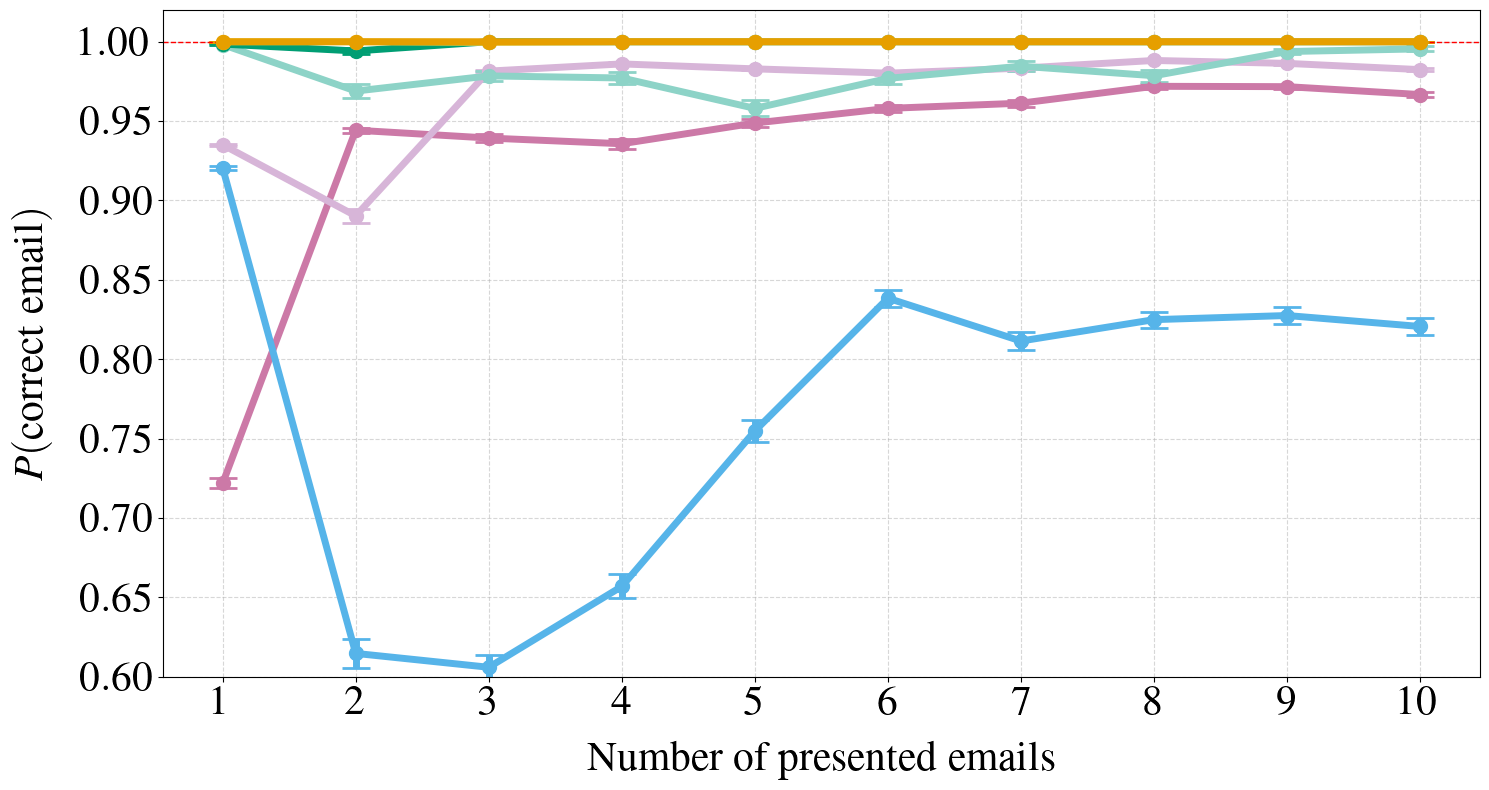

In [15]:
plot_together(df_dict_spam, family_colors, "Spam rule")

### Calculating performance scores

In [16]:
def calculate_performance_scores(df_dict):
    """
    Calculate the area between the actual performance curve and y=1 for each model
    """

    performance_scores = {}
    
    # for each model compare actual performance to perfect performance
    for model_name, df in df_dict.items():
        
        # Calculate average prob for each number of emails
        column_means = df.mean(axis=0)
        num_emails = column_means.index.astype(int)
        # Area under actual curve
        actual_area = np.trapezoid(column_means, num_emails)
    
        # Maximum possible area (y=1 line)
        max_area = np.trapezoid(np.ones_like(column_means), num_emails)
        
        # Deficit (how much area is "missing")
        deficit = max_area - actual_area
        
        # Normalized score (0 to 1, where 1 is perfect)
        normalized_score = actual_area / max_area
        
        performance_scores[model_name] = normalized_score

    return performance_scores

In [17]:
def calculate_overload_scores(df_dict):
    """
    Compare mean performance of choosing from small number of emails vs high number
    """

    performance_scores = {}
    
    # for each model compare actual performance to perfect performance
    for model_name, df in df_dict.items():
        
        # Calculate average prob for each number of emails
        column_means = df.mean(axis=0)
        small_number_mean = np.mean(column_means[1:3])
        high_number_mean = np.mean(column_means[-2:])
    
        difference = small_number_mean - high_number_mean
        performance_scores[model_name] = difference
        
    
    return performance_scores

In [18]:
performance_scores = {"Spam": calculate_performance_scores(df_dict_spam),
                      "Bystander": calculate_performance_scores(df_dict_bystander),
                      "Urgency": calculate_performance_scores(df_dict_urgency)}

overload_scores = {"Spam": calculate_overload_scores(df_dict_spam),
                      "Bystander": calculate_overload_scores(df_dict_bystander),
                      "Urgency": calculate_overload_scores(df_dict_urgency)}

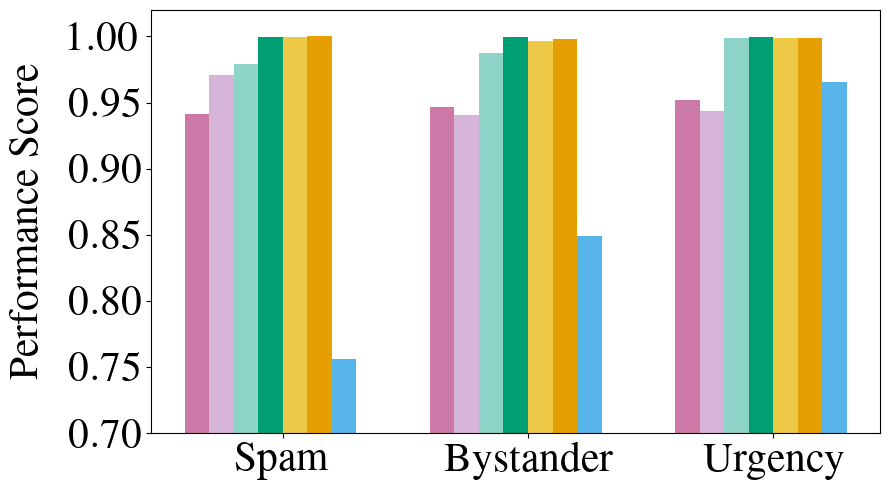

In [19]:

tasks = list(performance_scores.keys())
models = list(next(iter(performance_scores.values())).keys())

x = np.arange(len(tasks))   # task positions
width = 0.1 
plt.figure(figsize=(9, 5))

for i, model in enumerate(models):
    scores = [performance_scores[task][model] for task in tasks]
    
    plt.bar(
        x + i*width - (len(models)/2)*width,
        scores,
        width,
        label=model,
        color = family_colors[model]
    )

plt.xticks(x, tasks, fontsize = 30)
plt.yticks(fontsize = 30)
plt.ylabel("Performance Score", fontsize = 30, labelpad = 15)
plt.ylim(0.7, 1.02)
#plt.legend(ncol=3)
plt.tight_layout()
#plt.savefig(f"plots/benchmark/benchmark_performance.pdf")
plt.show()

    

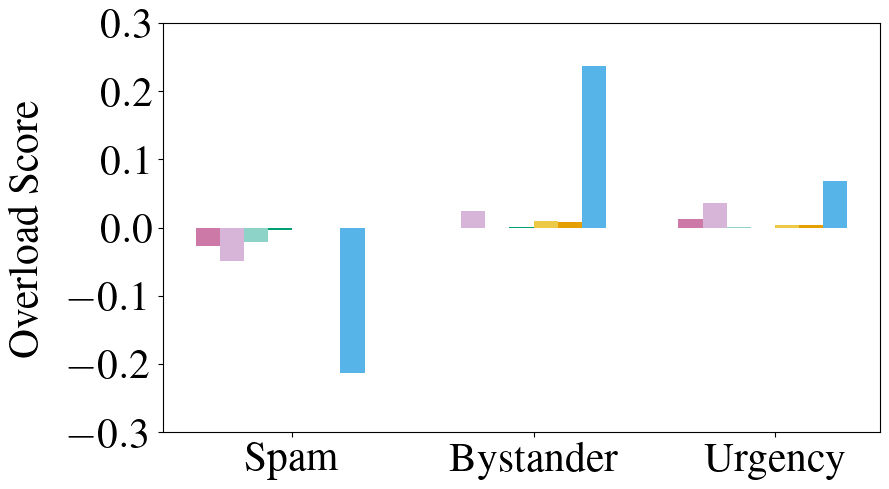

In [20]:

tasks = list(overload_scores.keys())
models = list(next(iter(overload_scores.values())).keys())

x = np.arange(len(tasks))   # task positions
width = 0.1
plt.figure(figsize=(9, 5))

for i, model in enumerate(models):
    scores = [overload_scores[task][model] for task in tasks]
    
    plt.bar(
        x + i*width - (len(models)/2)*width,
        scores,
        width,
        label=model,
        color = family_colors[model]
    )

plt.xticks(x, tasks, fontsize = 30)
plt.yticks(fontsize = 30)
plt.ylabel("Overload Score", fontsize = 30, labelpad = 15)
plt.ylim(-0.3, 0.3)
#plt.legend(ncol=3)
plt.tight_layout()
#plt.savefig(f"plots/benchmark/benchmark_overload.pdf")
plt.show()